<img src="../phData.png">

##### QUESTION TO ANSWER:

**"Has the model appropriately fit the dataset?"**

### 0 - Setup

In [20]:
import pandas as pd
import os, sys
import numpy as np
import json

# Data Viz
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

# ML
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

# Adjusting relative paths (going up one level from the notebooks folder to the root)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
# Adding the root to sys.path to be able to import things like config.py
sys.path.append(project_root)
from api.config import DATA_PATH, MODELS_PATH, MODEL_REQUIRED_FEATURES, MAIN_ENDPOINT_INPUT_SCHEMA, SALES_DATA_COLUMNS, SALES_DATA_FEATURES

# Data to load
kc_sales_data_path = os.path.join(DATA_PATH, "kc_house_data.csv")
demographic_data_path = os.path.join(DATA_PATH, "zipcode_demographics.csv")
future_unseen_data_path = os.path.join(DATA_PATH, 'future_unseen_examples.csv')

### 1- Model & Data Loading

In [2]:
# Loading model
model = joblib.load(os.path.join(MODELS_PATH, "model.pkl"))

# Loading data
kc_sales_data = pd.read_csv(kc_sales_data_path, usecols=SALES_DATA_COLUMNS, dtype={'zipcode': str})
future_unseen_data = pd.read_csv(future_unseen_data_path, usecols=MAIN_ENDPOINT_INPUT_SCHEMA, dtype={'zipcode': str})
demographics_data = pd.read_csv(demographic_data_path, dtype={'zipcode': str})
# Merging kc_sales_data with demographics data
merged_data = kc_sales_data.merge(demographics_data, how='left', on='zipcode')

In [3]:
merged_data.head()

#### Splitting

In [4]:
# Split X and y
y = merged_data.pop('price')
X = merged_data[MODEL_REQUIRED_FEATURES]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 2 - Predicting & Evaluating

In [5]:
# Predicting on train and test
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Defining metrics
def evaluate(y_true, y_pred, dataset_name=''):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{dataset_name} Metrics:")
    print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
    print(f"MAE (Mean Absolute Error):  {mae:.2f}")
    print(f"R²:   {r2:.3f}")

# Evaluating
evaluate(y_train, y_pred_train, "Train")
evaluate(y_test, y_pred_test, "Test")


Train Metrics:
RMSE (Root Mean Squared Error): 147457.29
MAE (Mean Absolute Error):  77782.97
R²:   0.834

Test Metrics:
RMSE (Root Mean Squared Error): 202611.26
MAE (Mean Absolute Error):  102316.22
R²:   0.728


First impressions: Model generalizes OK. There's a slight overfit considering that Train metrics are little bit higher than Test metrics (but not so strong).

---

#### Residual Plot

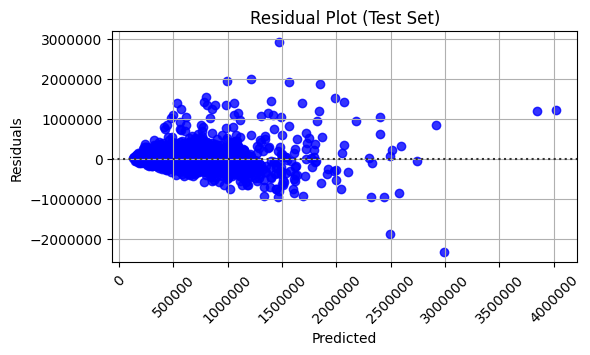

In [32]:
# Residual plot
plt.figure(figsize=(6,3))
sns.residplot(x=y_pred_test, y=y_test - y_pred_test, color="blue")

# Settings
plt.title("Residual Plot (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.grid(True)
plt.ticklabel_format(style='plain', axis='both')
plt.xticks(rotation=45)
plt.show()

#### Predicted vs Actual

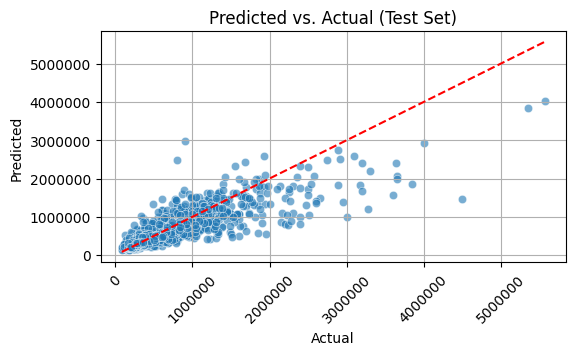

In [26]:
# Predicted vs Real
plt.figure(figsize=(6,3))
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

# Settings
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs. Actual (Test Set)")
plt.grid(True)
plt.ticklabel_format(style='plain', axis='both')
plt.xticks(rotation=45)
plt.show()

Apparently, as the real value of a property increases, the model tends to undervalue it, performing "better" (with a more even distribution between overvaluation and undervaluation) for more "common" properties.

This might happen mainly due to a reason: the data volume (records for training the model) is much more abundant for "average" or more "common" properties than for high-value properties. This is partly due to directional scarcity. This causes the model to weight its learning more significantly on those data.

Let's evaluate whether the model actually performs differently for different property value ranges.

In [50]:
# Evaluating a US$ 2 million threshold
threshold = 2_000_000
high_value_houses = y_test > threshold
low_value_houses = y_test <= threshold
print(f"\nNumber of houses below or equal to ${threshold}: {len(y_test[low_value_houses])}")
print(f"\nNumber of houses above ${threshold}: {len(y_test[high_value_houses])}")



Number of houses below or equal to $2000000: 4273

Number of houses above $2000000: 50


---

### 3- Testing Predictions for Different Property Values

In [42]:
# Creating Price bins using quantiles (equal bins)
num_bins = 5
bins = pd.qcut(y_test, q=num_bins, duplicates='drop')

# Creating DataFrame with actual, predicted values and residuals
df_errors = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred_test,
    'residual': y_test - y_pred_test,
    'abs_residual': (y_test - y_pred_test).abs(),
    'bin': bins
})

In [ ]:
# Grouping by bin and calculate error statistics
error_stats = df_errors.groupby('bin', observed=True).agg({
    'residual': ['mean', 'std'],
    'abs_residual': ['mean', 'std'],
    'actual': ['min', 'max', 'count']
}).reset_index()

# Renaming columns for clarity
error_stats.columns = ['bin', 'residual_mean', 'residual_std', 'abs_residual_mean', 'abs_residual_std', 'actual_min', 'actual_max', 'count']

#### Plotting Mean Residual Errors by Price Bin

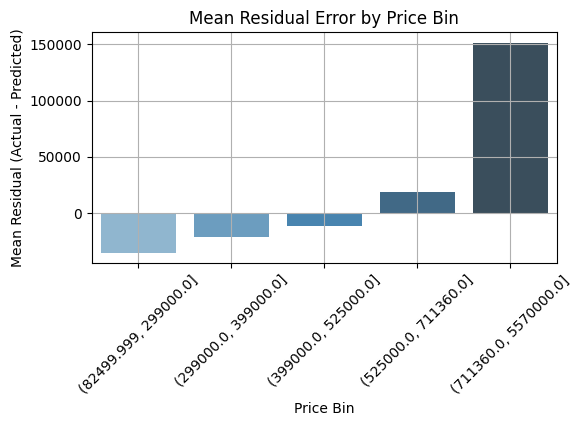

In [44]:
plt.figure(figsize=(6,3))
sns.barplot(x='bin', y='residual_mean', data=error_stats, palette='Blues_d', hue='bin', legend=False)

# Chart Settings
plt.title('Mean Residual Error by Price Bin')
plt.xlabel('Price Bin')
plt.ylabel('Mean Residual (Actual - Predicted)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

This visualization confirms the initial thesis that the model tends to undervalue properties with higher real values.

Finally, answering the main question ("Has the model appropriately fit the dataset?")

**A: The model performs reasonably well on average. The metrics on the test data are slightly lower than on the training data, indicating mild overfitting.**

**As shown, the model tends to fit better for properties with average prices (where there is also more data to train the model). For properties with actual value > US$2 million, the model tends to underestimate their true price, indicating a point of improvement.**

My recommendations would be to evaluate some actions:

- **Model selection:** Experiment with models that can better handle sparse regions in feature space, such as Random Forest Regressor, XGBoost with tuned hyperparameters. My experience is that these models tend to be the best performers in this specific real estate scenario.

- **Target transformation:** Consider transforming the target variable (e.g., log transformation) to reduce the scale effect between low and high-value properties.

- **Data augmentation:** Investigate oversampling or synthetic data generation for the high-price segment to give the model more examples in this range, or even evaluate downsampling dominant data range.

- **Segmented modeling:** It might be interesting to create different models for different price categories, being these price bins determined by an exploratory analysis of data as well as domain knowledge from real estate experts.

---